In [4]:
import cv2
import numpy as np
import glob
import os
from zipfile import ZipFile

# Unzip the uploaded files
for zip_file in ["left.zip", "right.zip"]:
    with ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()

print("Files extracted successfully!")


Files extracted successfully!


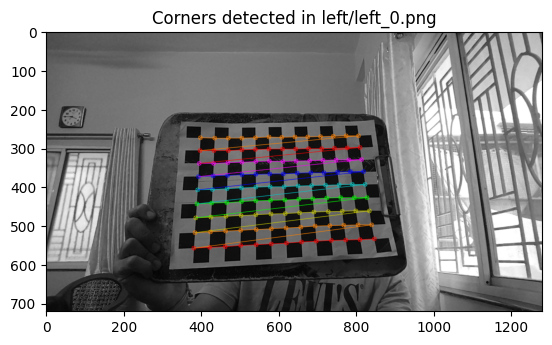

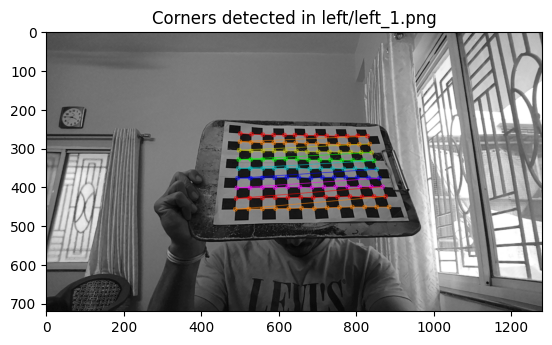

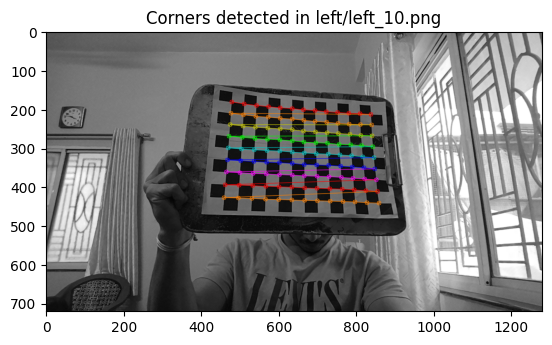

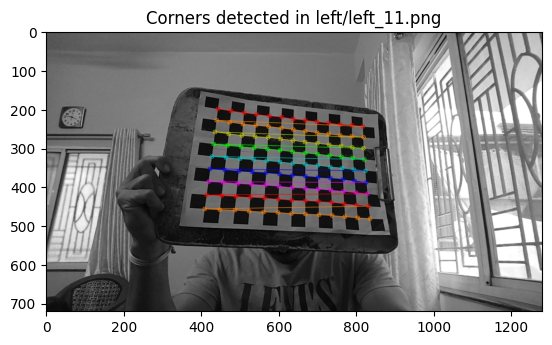

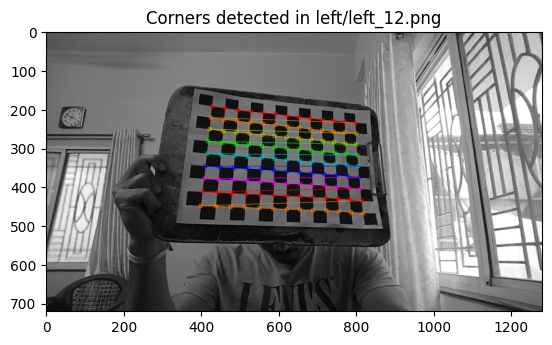

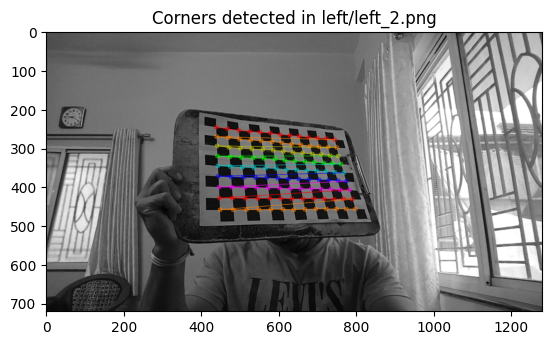

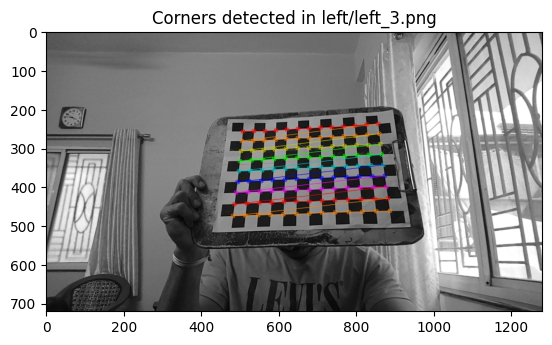

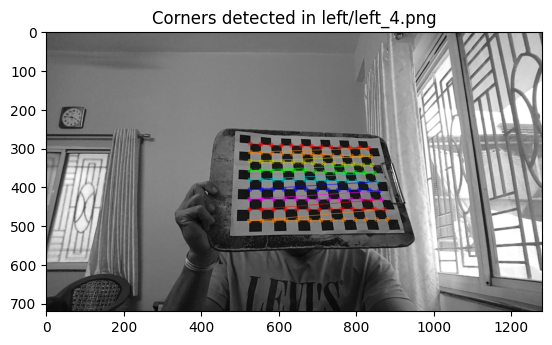

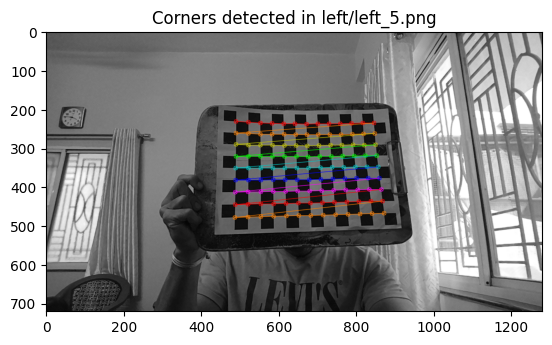

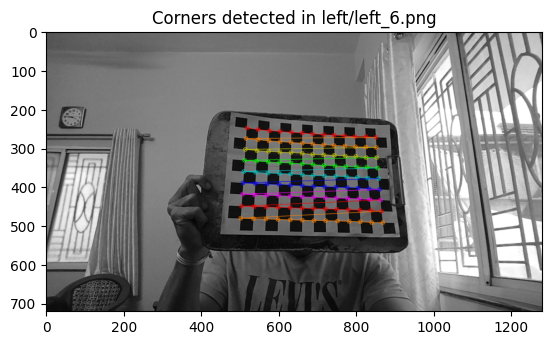

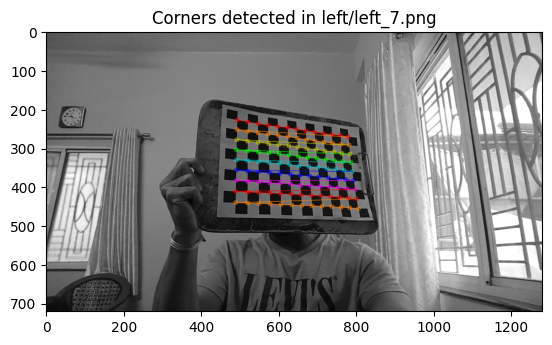

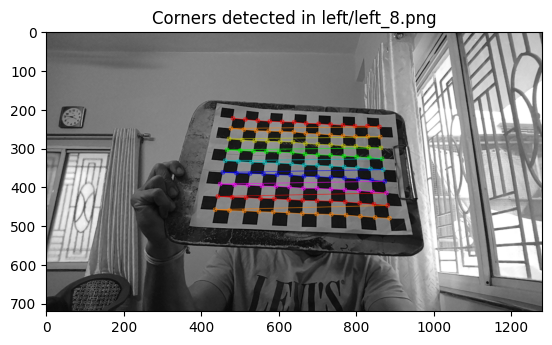

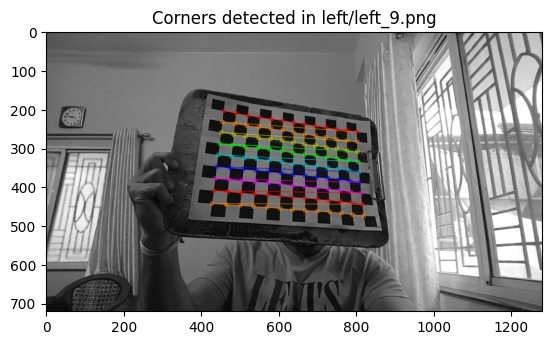

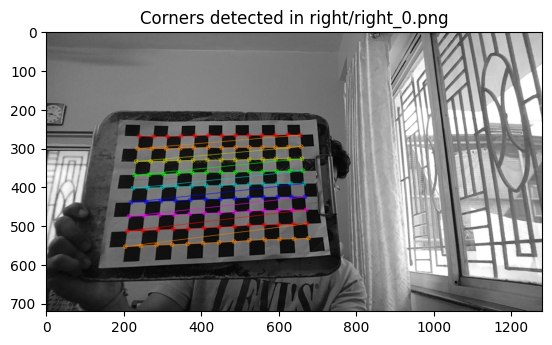

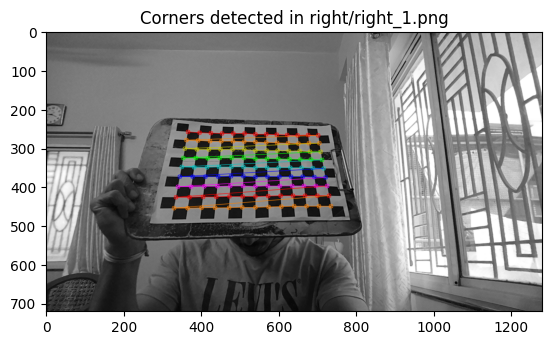

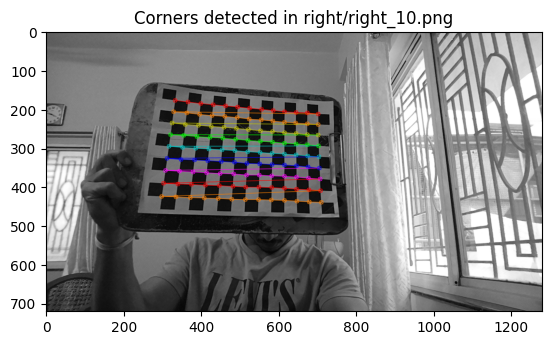

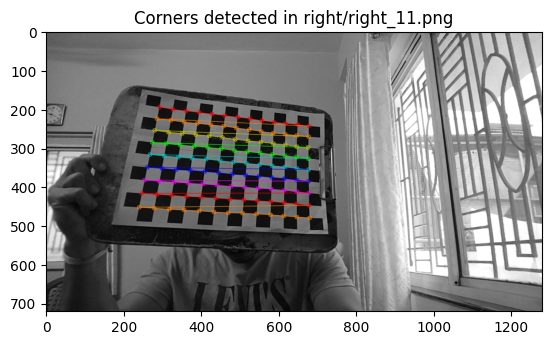

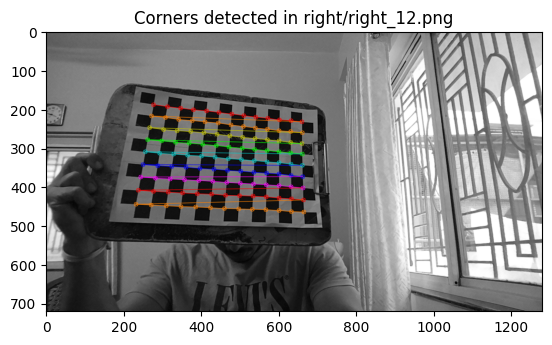

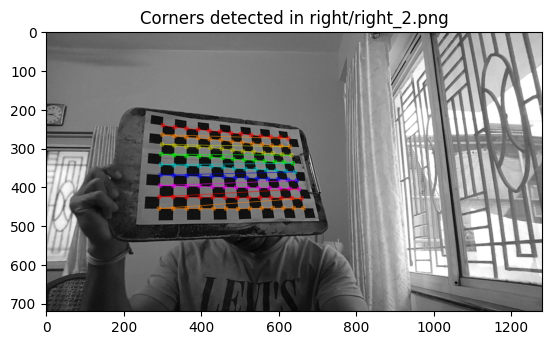

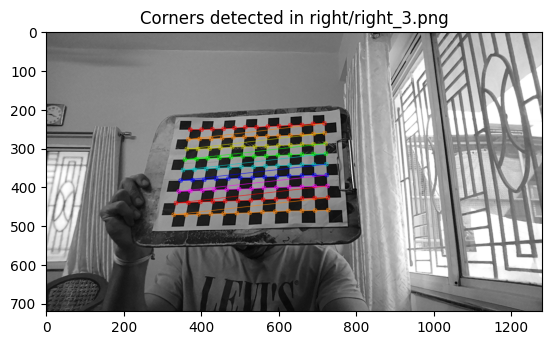

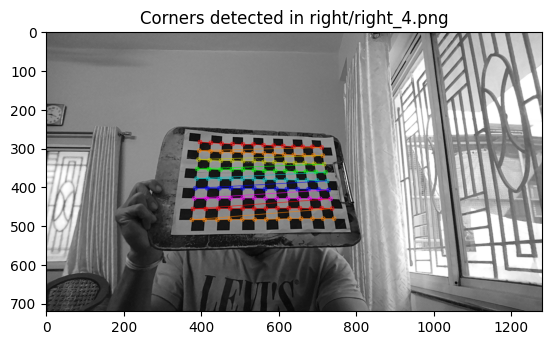

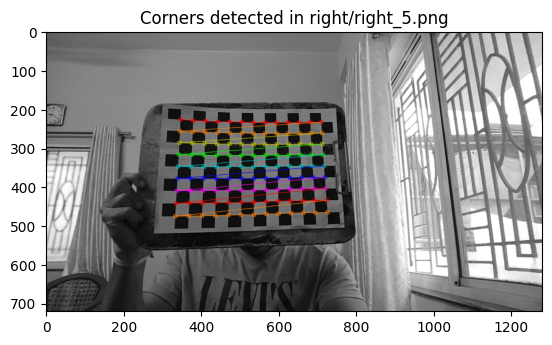

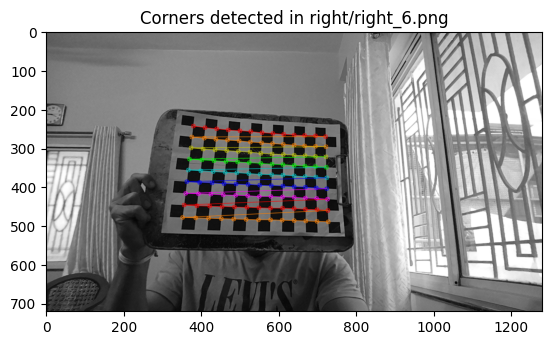

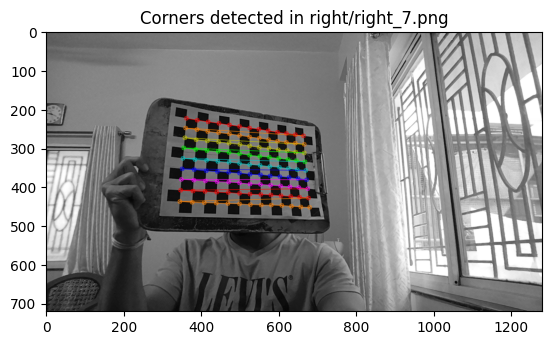

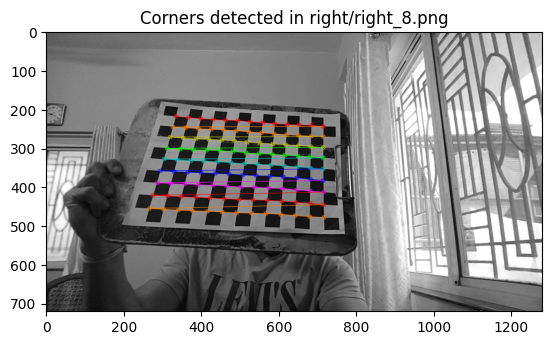

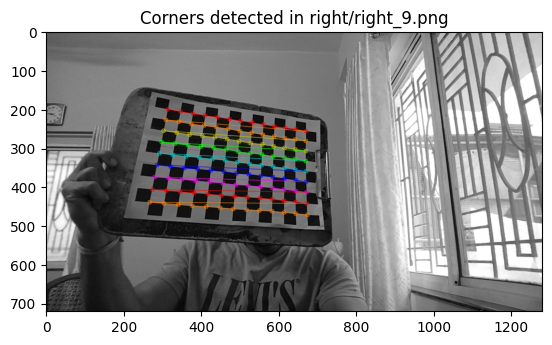

Corners detected!


In [5]:
import matplotlib.pyplot as plt

CHECKERBOARD = (13, 9)  # Internal corners for a 14x10 checkerboard
square_size = 20  # Size of one square in mm (adjust as per your checkerboard)

objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= square_size

# Arrays to store object points and image points from all images
objpoints = []  # 3D points in real world space
imgpoints_left = []  # 2D points for left camera
imgpoints_right = []  # 2D points for right camera

def detect_corners(folder, pattern_size):
    points = []
    images = sorted(glob.glob(f"{folder}/*.png"))
    for image_file in images:
        img = cv2.imread(image_file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        if ret:
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                       criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

            cv2.drawChessboardCorners(img, pattern_size, corners, ret)

            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Corners detected in {image_file}")
            plt.show()

            points.append(corners)
        else:
            print(f"Checkerboard not detected in {image_file}")
    return points

imgpoints_left = detect_corners('left', CHECKERBOARD)
imgpoints_right = detect_corners('right', CHECKERBOARD)

objpoints = [objp] * len(imgpoints_left)

print("Corners detected!")


left Camera Matrix:
 [[795.33418552   0.         702.82366096]
 [  0.         790.77446983 373.11222447]
 [  0.           0.           1.        ]]
left Distortion Coefficients:
 [[ 0.23337697 -0.96872541  0.00283716  0.02545211  1.48882589]]


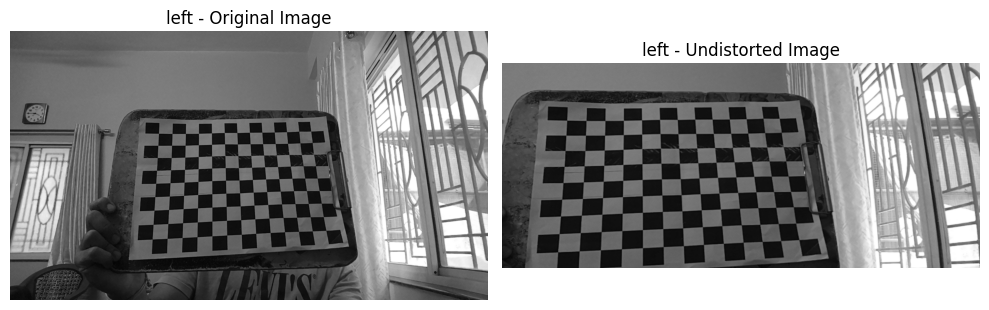

right Camera Matrix:
 [[794.0268005    0.         662.01757094]
 [  0.         787.05649809 378.97567678]
 [  0.           0.           1.        ]]
right Distortion Coefficients:
 [[ 0.38595148 -1.42425364  0.00569936  0.02769671  1.79437831]]


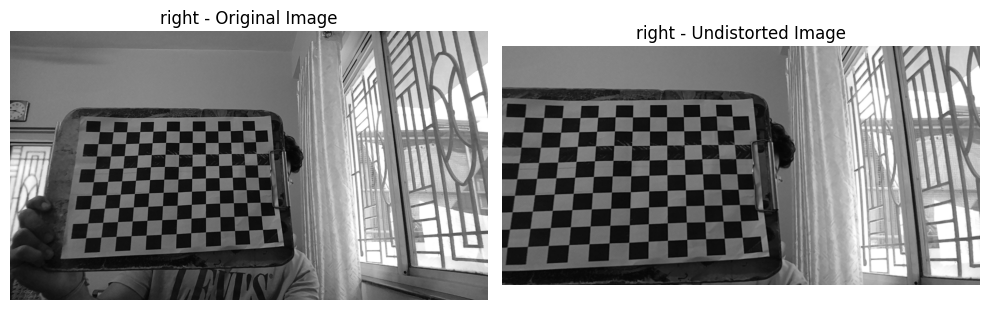

In [6]:
import cv2
import numpy as np
import glob
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt

img = cv2.imread(sorted(glob.glob("left/*.png"))[0])
img_shape = img.shape[:2][::-1]  # (width, height)

def calibrate_single_camera_and_visualize(objpoints, imgpoints, img_shape, camera_name):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    print(f"{camera_name} Camera Matrix:\n", mtx)
    print(f"{camera_name} Distortion Coefficients:\n", dist)

    img_path = sorted(glob.glob(f"{camera_name}/*.png"))[0]  # Get the first image
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    x, y, w, h = roi
    dst = dst[y:y + h, x:x + w]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"{camera_name} - Original Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"{camera_name} - Undistorted Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    return mtx, dist

left_mtx, left_dist = calibrate_single_camera_and_visualize(objpoints, imgpoints_left, img_shape, "left")
right_mtx, right_dist = calibrate_single_camera_and_visualize(objpoints, imgpoints_right, img_shape, "right")


In [7]:
flags = cv2.CALIB_FIX_INTRINSIC
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpoints_left, imgpoints_right,
    left_mtx, left_dist, right_mtx, right_dist,
    img_shape, criteria=criteria, flags=flags
)

print("Rotation Matrix:\n", R)
print("Translation Vector:\n", T)

Rotation Matrix:
 [[ 0.56920101  0.05055711  0.82064255]
 [ 0.31063788  0.91090597 -0.27157764]
 [-0.76125838  0.40950493  0.50278365]]
Translation Vector:
 [[-480.26620241]
 [ 131.51316917]
 [ 256.28401579]]


In [8]:
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    left_mtx, left_dist, right_mtx, right_dist,
    img_shape, R, T, alpha=0
)

print("Disparity-to-Depth Mapping Matrix (Q):\n", Q)


Disparity-to-Depth Mapping Matrix (Q):
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -5.32440831e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -3.23257203e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.28959013e+04]
 [ 0.00000000e+00  0.00000000e+00  1.78562081e-03 -0.00000000e+00]]


In [9]:
import pickle

calibration_data = {
    "left_mtx": left_mtx, "left_dist": left_dist,
    "right_mtx": right_mtx, "right_dist": right_dist,
    "R": R, "T": T, "E": E, "F": F, "Q": Q
}

with open('stereo_calibration.pkl', 'wb') as f:
    pickle.dump(calibration_data, f)

print("Calibration data saved!")


Calibration data saved!


Image Shape: (1280, 720)


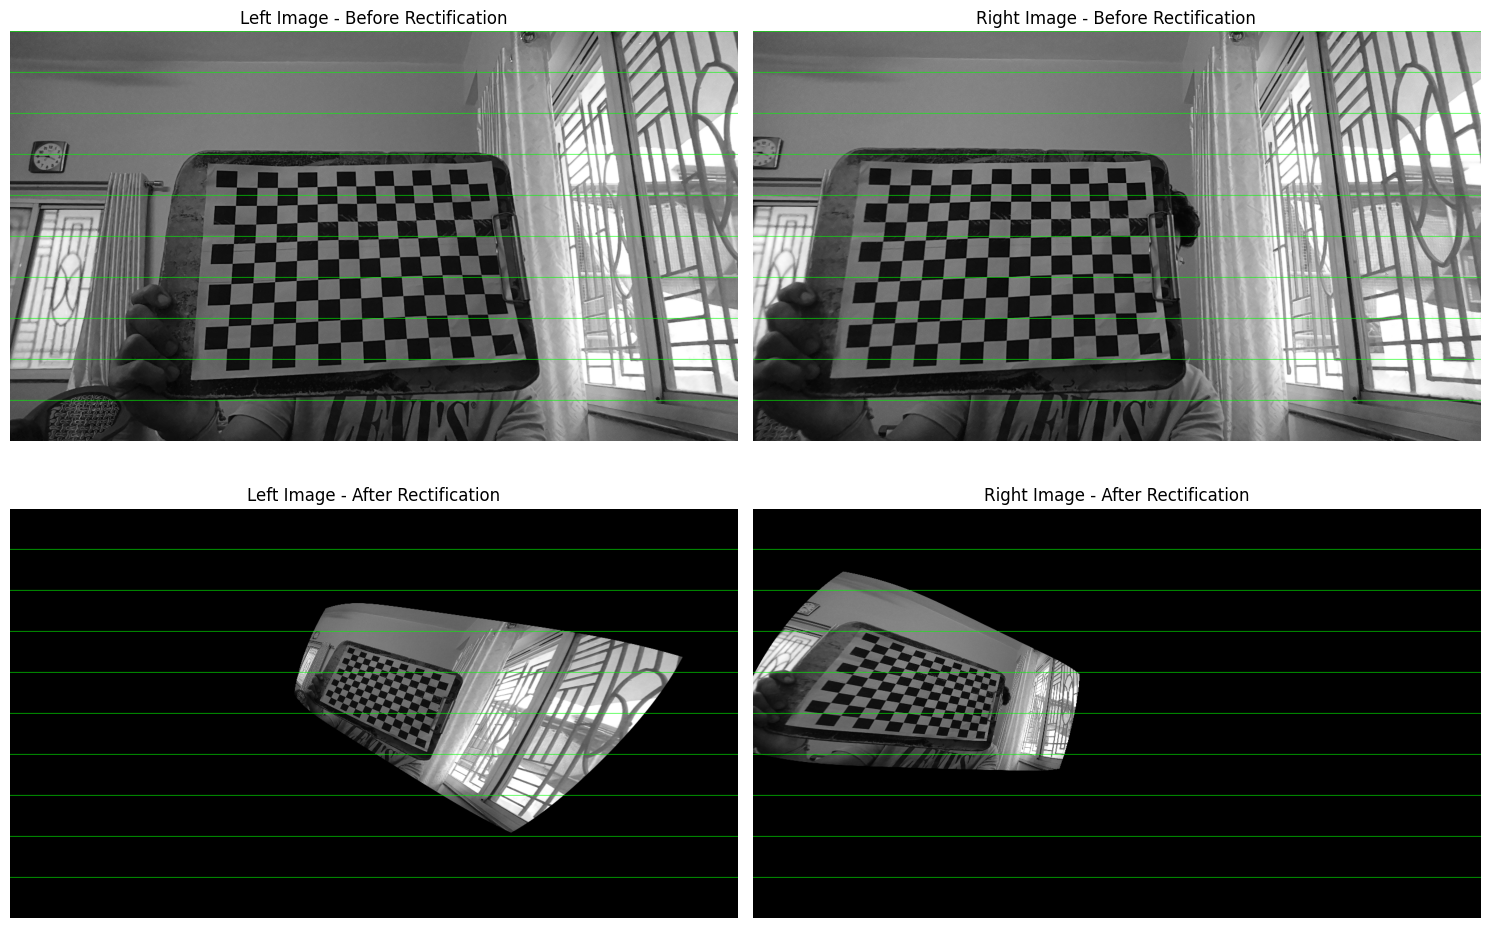

In [10]:
def visualize_rectification_debug(left_images_folder, right_images_folder, calibration_data, pattern_size):
    import matplotlib.pyplot as plt

    with open(calibration_data, 'rb') as f:
        calib = pickle.load(f)

    left_mtx = calib['left_mtx']
    left_dist = calib['left_dist']
    right_mtx = calib['right_mtx']
    right_dist = calib['right_dist']
    R = calib['R']
    T = calib['T']

    left_img_path = sorted(glob.glob(f"{left_images_folder}/*.png"))[0]
    right_img_path = sorted(glob.glob(f"{right_images_folder}/*.png"))[0]
    left_img = cv2.imread(left_img_path)
    right_img = cv2.imread(right_img_path)

    img_shape = left_img.shape[:2][::-1]
    print(f"Image Shape: {img_shape}")

    alpha = 1  # Try different values: 0, 0.5, 1
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        left_mtx, left_dist, right_mtx, right_dist,
        img_shape, R, T, alpha=alpha
    )

    map1_left, map2_left = cv2.initUndistortRectifyMap(
        left_mtx, left_dist, R1, P1, img_shape, cv2.CV_16SC2
    )
    map1_right, map2_right = cv2.initUndistortRectifyMap(
        right_mtx, right_dist, R2, P2, img_shape, cv2.CV_16SC2
    )
    rectified_left = cv2.remap(left_img, map1_left, map2_left, cv2.INTER_LINEAR)
    rectified_right = cv2.remap(right_img, map1_right, map2_right, cv2.INTER_LINEAR)

    def draw_lines(img, color=(0, 255, 0)):
        step = img.shape[0] // 10
        for y in range(0, img.shape[0], step):
            img = cv2.line(img, (0, y), (img.shape[1], y), color, 1)
        return img

    left_with_lines = draw_lines(left_img.copy())
    right_with_lines = draw_lines(right_img.copy())
    rectified_left_lines = draw_lines(rectified_left.copy())
    rectified_right_lines = draw_lines(rectified_right.copy())

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].imshow(cv2.cvtColor(left_with_lines, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Left Image - Before Rectification")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(cv2.cvtColor(right_with_lines, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title("Right Image - Before Rectification")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(cv2.cvtColor(rectified_left_lines, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title("Left Image - After Rectification")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(cv2.cvtColor(rectified_right_lines, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title("Right Image - After Rectification")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

visualize_rectification_debug('left', 'right', 'stereo_calibration.pkl', CHECKERBOARD)
